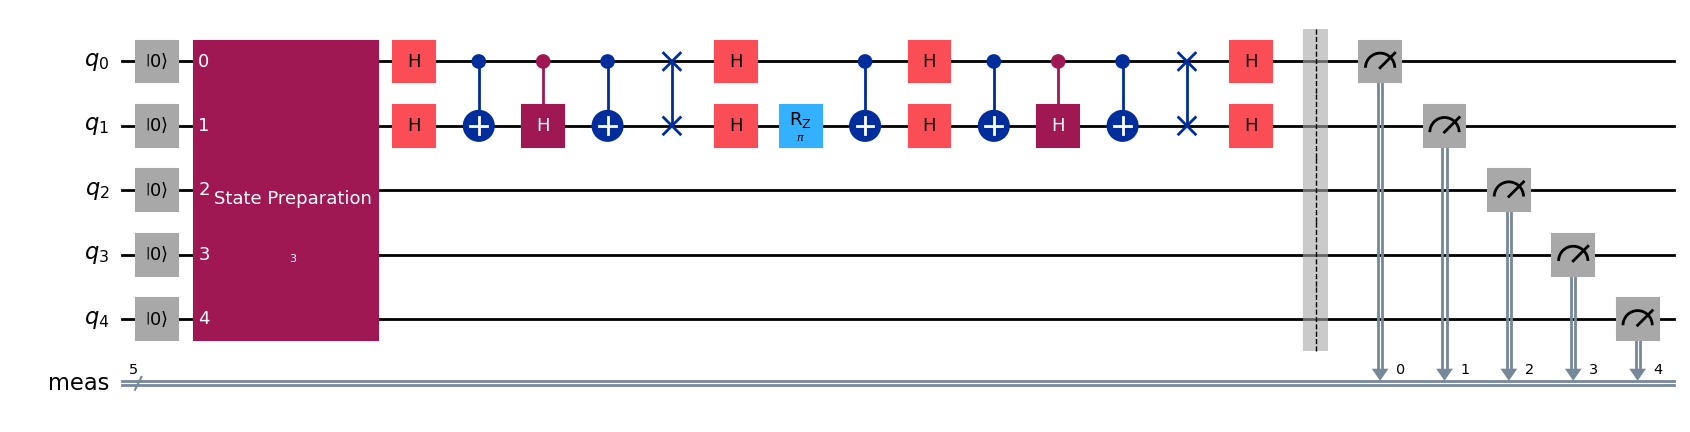

In [55]:

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
import numpy as np


size = 5

qreg_q = QuantumRegister(size, 'q')
creg_c = ClassicalRegister(size, 'c')
circuit = QuantumCircuit(qreg_q)

circuit.h(qreg_q[0])
circuit.h(qreg_q[1])
circuit.cx(qreg_q[0], qreg_q[1])
circuit.ch(qreg_q[0], qreg_q[1])
circuit.cx(qreg_q[0], qreg_q[1])
circuit.swap(qreg_q[0], qreg_q[1])
circuit.h(qreg_q[0])
circuit.h(qreg_q[1])
circuit.rz(np.pi, qreg_q[1])
circuit.cx(qreg_q[0], qreg_q[1])
circuit.h(qreg_q[0])
circuit.h(qreg_q[1])
circuit.cx(qreg_q[0], qreg_q[1])
circuit.ch(qreg_q[0], qreg_q[1])
circuit.cx(qreg_q[0], qreg_q[1])
circuit.swap(qreg_q[0], qreg_q[1])
circuit.h(qreg_q[0])
circuit.h(qreg_q[1])



tests = range(1,int(2**size))

circuit_list = []

for test in tests:
    circuit_sampler = QuantumCircuit(qreg_q)
    circuit_sampler.initialize(test)
    circuit_sampler.append(circuit.to_instruction(),[0,1,2,3,4])
    circuit_sampler.measure_all()
    circuit_list += [circuit_sampler]
    
circuit_list[2].decompose().draw()
    

In [56]:
from qiskit.primitives import Sampler
import pandas as pd
    
sampler = Sampler()

job = sampler.run(circuit_list,shots = 2000)
result = job.result()

df = pd.DataFrame(list(enumerate(result.quasi_dists,1)))

df.set_index(0, inplace=True)

df

,1
0,
1,"{0: 0.3605, 1: 0.054, 2: 0.019, 3: 0.5665}"
2,"{0: 0.0585, 1: 0.0085, 2: 0.919, 3: 0.014}"
3,"{0: 0.1995, 1: 0.3645, 2: 0.063, 3: 0.373}"
4,"{4: 0.3545, 5: 0.5705, 6: 0.014, 7: 0.061}"
5,"{4: 0.363, 5: 0.0655, 6: 0.0075, 7: 0.564}"
6,"{4: 0.0655, 5: 0.0095, 6: 0.9175, 7: 0.0075}"
7,"{4: 0.204, 5: 0.3705, 6: 0.0645, 7: 0.361}"
8,"{8: 0.3735, 9: 0.546, 10: 0.0095, 11: 0.071}"
9,"{8: 0.3425, 9: 0.065, 10: 0.008, 11: 0.5845}"


In [57]:
df = df[1].apply(dict.items).explode().apply(pd.Series).rename(columns={0: 1, 1: "one"})
df[1] = df[1].astype(int)
df.set_index(1, append=True, inplace=True)

circuit_list_two = []

for test in list(df.index.get_level_values(1)):
    circuit_sampler = QuantumCircuit(qreg_q)
    circuit_sampler.initialize(test)
    circuit_sampler.append(circuit.to_instruction(),[0,1,2,3,4])
    circuit_sampler.measure_all()
    circuit_list_two += [circuit_sampler]
    
job_two = sampler.run(circuit_list_two,shots = 2000).result()

df["two"] = pd.DataFrame(list(enumerate(job_two.quasi_dists,1)))[1].values

df

one                                               two
0  1                                                           
1  0   0.3605      {0: 0.3725, 1: 0.5515, 2: 0.0095, 3: 0.0665}
   1   0.0540          {0: 0.3735, 1: 0.0665, 2: 0.01, 3: 0.55}
   2   0.0190        {0: 0.058, 1: 0.007, 2: 0.9245, 3: 0.0105}
   3   0.5665      {0: 0.1835, 1: 0.3695, 2: 0.0645, 3: 0.3825}
2  0   0.0585         {0: 0.3735, 1: 0.56, 2: 0.009, 3: 0.0575}
...       ...                                               ...
30 31  0.0115     {28: 0.2085, 29: 0.36, 30: 0.0625, 31: 0.369}
31 28  0.2305    {28: 0.347, 29: 0.5845, 30: 0.012, 31: 0.0565}
   29  0.3425    {28: 0.351, 29: 0.0565, 30: 0.0105, 31: 0.582}
   30  0.0610    {28: 0.063, 29: 0.017, 30: 0.9075, 31: 0.0125}
   31  0.3660  {28: 0.1875, 29: 0.3655, 30: 0.0735, 31: 0.3735}

[124 rows x 2 columns]

In [58]:
dft = df["two"].apply(dict.items).explode().apply(pd.Series).rename(columns={0: 2, 1: "two"})
df = df["one"].to_frame().join(dft)
df[2] = df[2].astype(int)
df.set_index(2, append=True, inplace=True)

circuit_list_three = []

for test in list(df.index.get_level_values(2)):
    circuit_sampler = QuantumCircuit(qreg_q)
    circuit_sampler.initialize(test)
    circuit_sampler.append(circuit.to_instruction(),[0,1,2,3,4])
    circuit_sampler.measure_all()
    circuit_list_three += [circuit_sampler]
    
job_three = sampler.run(circuit_list_three,shots = 2000).result()

df["three"] = pd.DataFrame(list(enumerate(job_three.quasi_dists,1)))[1].values

df

one     two                                             three
0  1  2                                                                   
1  0  0   0.3605  0.3725         {0: 0.3765, 1: 0.5525, 2: 0.011, 3: 0.06}
      1   0.3605  0.5515        {0: 0.363, 1: 0.072, 2: 0.0095, 3: 0.5555}
      2   0.3605  0.0095        {0: 0.066, 1: 0.0095, 2: 0.911, 3: 0.0135}
      3   0.3605  0.0665          {0: 0.212, 1: 0.366, 2: 0.071, 3: 0.351}
   1  0   0.0540  0.3735        {0: 0.376, 1: 0.5535, 2: 0.012, 3: 0.0585}
...          ...     ...                                               ...
31 30 31  0.0610  0.0125    {28: 0.218, 29: 0.3695, 30: 0.064, 31: 0.3485}
   31 28  0.3660  0.1875    {28: 0.355, 29: 0.5685, 30: 0.0105, 31: 0.066}
      29  0.3660  0.3655    {28: 0.369, 29: 0.0545, 30: 0.0115, 31: 0.565}
      30  0.3660  0.0735    {28: 0.069, 29: 0.008, 30: 0.9115, 31: 0.0115}
      31  0.3660  0.3735  {28: 0.2255, 29: 0.3495, 30: 0.0625, 31: 0.3625}

[496 rows x 3 columns]

In [59]:
dft = df["three"].apply(dict.items).explode().apply(pd.Series).rename(columns={0: 3, 1: "three"})
df = df[["one","two"]].join(dft)
df[3] = df[3].astype(int)
df.set_index(3, append=True, inplace=True)

df["probs"] = (df["one"]) + (df["two"]) + (df["three"])

df.head(50)

one     two   three   probs
0 1 2 3                                
1 0 0 0  0.3605  0.3725  0.3765  1.1095
      1  0.3605  0.3725  0.5525  1.2855
      2  0.3605  0.3725  0.0110  0.7440
      3  0.3605  0.3725  0.0600  0.7930
    1 0  0.3605  0.5515  0.3630  1.2750
      1  0.3605  0.5515  0.0720  0.9840
      2  0.3605  0.5515  0.0095  0.9215
      3  0.3605  0.5515  0.5555  1.4675
    2 0  0.3605  0.0095  0.0660  0.4360
      1  0.3605  0.0095  0.0095  0.3795
      2  0.3605  0.0095  0.9110  1.2810
      3  0.3605  0.0095  0.0135  0.3835
    3 0  0.3605  0.0665  0.2120  0.6390
      1  0.3605  0.0665  0.3660  0.7930
      2  0.3605  0.0665  0.0710  0.4980
      3  0.3605  0.0665  0.3510  0.7780
  1 0 0  0.0540  0.3735  0.3760  0.8035
      1  0.0540  0.3735  0.5535  0.9810
      2  0.0540  0.3735  0.0120  0.4395
      3  0.0540  0.3735  0.0585  0.4860
    1 0  0.0540  0.0665  0.3545  0.4750
      1  0.0540  0.0665  0.0630  0.1835
      2  0.0540  0.0665  0.0110  0.1315
      3  0.0540  0.0665  0.5715  0.6920
    2 0  0.0540  0.0100  0.0560  0.1200
      1  0.0540  0.0100  0.0100  0.0740
      2  0.0540  0.0100  0.9225  0.9865
      3  0.0540  0.0100  0.0115  0.0755
    3 0  0.0540  0.5500  0.2085  0.8125
      1  0.0540  0.5500  0.3460  0.9500
      2  0.0540  0.5500  0.0700  0.6740
      3  0.0540  0.5500  0.3755  0.9795
  2 0 0  0.0190  0.0580  0.3515  0.4285
      1  0.0190  0.0580  0.5660  0.6430
      2  0.0190  0.0580  0.0135  0.0905
      3  0.0190  0.0580  0.0690  0.1460
    1 0  0.0190  0.0070  0.3730  0.3990
      1  0.0190  0.0070  0.0650  0.0910
      2  0.0190  0.0070  0.0070  0.0330
      3  0.0190  0.0070  0.5550  0.5810
    2 0  0.0190  0.9245  0.0715  1.0150
      1  0.0190  0.9245  0.0090  0.9525
      2  0.0190  0.9245  0.9135  1.8570
      3  0.0190  0.9245  0.0060  0.9495
    3 0  0.0190  0.0105  0.2185  0.2480
      1  0.0190  0.0105  0.3555  0.3850
      2  0.0190  0.0105  0.0555  0.0850
      3  0.0190  0.0105  0.3705  0.4000
  3 0 0  0.5665  0.1835  0.3660  1.1160
      1  0.5665  0.1835  0.5590  1.3090

In [61]:
df.groupby(level=[0])["probs"].nlargest(1)

0   0   1   2   3 
1   1   2   2   2     1.8570
2   2   2   2   2     2.7575
3   3   2   2   2     1.9035
4   4   6   6   6     1.8370
5   5   6   6   6     1.8335
6   6   6   6   6     2.7495
7   7   6   6   6     1.9140
8   8   10  10  10    1.8345
9   9   10  10  10    1.8220
10  10  10  10  10    2.7505
11  11  10  10  10    1.9000
12  12  14  14  14    1.8455
13  13  14  14  14    1.8210
14  14  14  14  14    2.7495
15  15  14  14  14    1.8805
16  16  18  18  18    1.8395
17  17  18  18  18    1.8485
18  18  18  18  18    2.7520
19  19  18  18  18    1.9055
20  20  22  22  22    1.8600
21  21  22  22  22    1.8430
22  22  22  22  22    2.7440
23  23  22  22  22    1.9080
24  24  26  26  26    1.8310
25  25  26  26  26    1.8315
26  26  26  26  26    2.7510
27  27  26  26  26    1.8925
28  28  30  30  30    1.8485
29  29  30  30  30    1.8515
30  30  30  30  30    2.7285
31  31  30  30  30    1.8910
Name: probs, dtype: float64